# Culstering Exploration

In [1]:
1

1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import cartopy.crs as crs

Data downloaded from

In [2]:
# https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240416T162518.L2.OC_AOP.V1_0_0.NRT.nc

In [3]:
# https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240413T175156.L2.OC_AOP.V1_0_0.NRT.nc

In [ ]:
# https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240420T170201.L2.OC_AOP.V1_0_0.NRT.nc

In [4]:
fn = 'data/PACE_OCI.20240416T162518.L2.OC_AOP.V1_0_0.NRT.nc'

In [3]:
fn = 'data/PACE_OCI.20240413T175156.L2.OC_AOP.V1_0_0.NRT.nc'

In [3]:
fn = 'data/PACE_OCI.20240420T170201.L2.OC_AOP.V1_0_0.NRT.nc'

In [4]:
def load_oci_l2(fn, full_flag = True):
    # create the initial dataset so that we have all the attributes
    xds = xr.open_dataset(fn)
    # open the file with netCDF to get all the actual data
    dataset = Dataset(fn)
    
    # grab the necessary group data
    gd    = dataset.groups['geophysical_data']
    nav   = dataset.groups['navigation_data']
    lons  = nav.variables["longitude"][:]
    lats  = nav.variables["latitude"][:]
    flags = gd.variables["l2_flags"][:]
    wls = dataset.groups['sensor_band_parameters']['wavelength_3d'][:].data

    # create the dataset, now we're only adding in Rrs
    # but the options are: ['Rrs', 'Rrs_unc', 'aot_865', 'angstrom', 'avw', 'l2_flags']
    rrs_xds = xr.Dataset({'Rrs':(('x', 'y', 'wl'),gd.variables['Rrs'][:].data)},
                        coords = {'latitude': (('x', 'y'), lats),
                                  'longitude': (('x', 'y'), lons),
                                  'wavelength' : ('wl', wls)},
                        attrs={'variable':'Remote sensing reflectance'})
    
    # merge back into the xarray dataset with all the attributes
    xds['Rrs'] = rrs_xds.Rrs
    # replace nodata areas with nan
    xds = xds.where(xds['Rrs'] != -32767.0)

    # eliminate everything that isn't a flag bit of 0 (meaning no flags)
    if full_flag:
        xds['Rrs'] = xr.where(xr.DataArray(flags.data, dims=['x', 'y'])==0, xds['Rrs'], np.nan)
        
    return(xds)

In [5]:
xds = load_oci_l2(fn, full_flag = True)

In [6]:
wls = xds.wavelength

(array([1.40200e+03, 8.73190e+04, 3.20871e+05, 4.67940e+05, 1.44400e+04,
        5.06000e+02, 8.80000e+01, 3.50000e+01, 9.00000e+00, 7.00000e+00]),
 array([-0.0009   ,  0.0027976,  0.0064952,  0.0101928,  0.0138904,
         0.017588 ,  0.0212856,  0.0249832,  0.0286808,  0.0323784,
         0.036076 ], dtype=float32),
 <BarContainer object of 10 artists>)

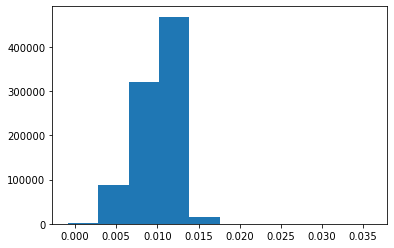

In [8]:
plt.hist(xds.Rrs[:,:,42].values.flatten())

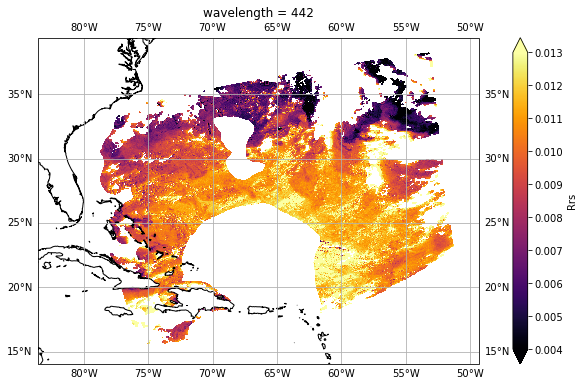

In [10]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

xds.Rrs[:,:,42].plot(ax=ax, x='longitude', y='latitude', vmin=0.004,vmax=0.013, cmap='inferno')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

In [9]:
# xds_subset = xds.where((xds.longitude > -72.5) & (xds.longitude < -70))
# xds_subset = xds_subset.where((xds_subset.latitude > 36) & (xds_subset.latitude < 42))

In [10]:
# xds_subset = xds.where((xds.longitude > -94) & (xds.longitude < -82))
# xds_subset = xds_subset.where((xds_subset.latitude > 22) & (xds_subset.latitude < 32))

In [11]:
xds_subset = xds.where((xds.longitude > -65) & (xds.longitude < -60))
xds_subset = xds_subset.where((xds_subset.latitude > 25) & (xds_subset.latitude < 30))

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


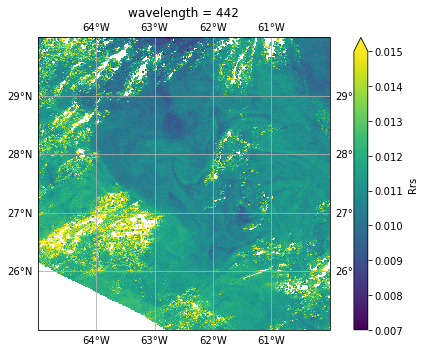

In [16]:
fig, ax = plt.subplots(figsize=(7,5), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

ax.set_xlim(-65,-60)
ax.set_ylim(25,30)

xds_subset.Rrs[:,:,42].plot(ax=ax, x='longitude', y='latitude', vmin=0.007,vmax=0.015, cmap='viridis')

gl = ax.gridlines(draw_labels=True)

fig.tight_layout()

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

In [14]:
flat_xds = xds_subset.Rrs.values.reshape(-1,184)

mask = ~np.isnan(flat_xds[:,40])
masked_flat_xds = flat_xds[mask]

rand_ints = np.random.randint(masked_flat_xds.shape[0],size=(50))

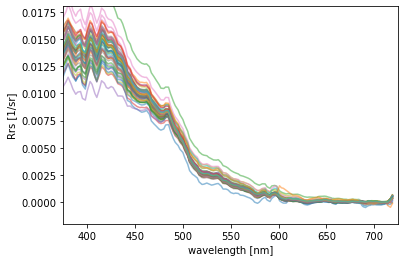

In [17]:
for spec_i in rand_ints:
    plt.plot(wls,masked_flat_xds[spec_i],alpha=0.5)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')
plt.ylim(-0.002,0.018)
plt.xlim(375,725)

fig.tight_layout()

# plt.savefig('figs/spectra_examples_nw_atlantic_oci.png',dpi=300)

plt.show()

In [14]:
masked_flat_xds.shape

(20740, 184)

ValueError: x and y must have same first dimension, but have shapes (8,) and (5,)

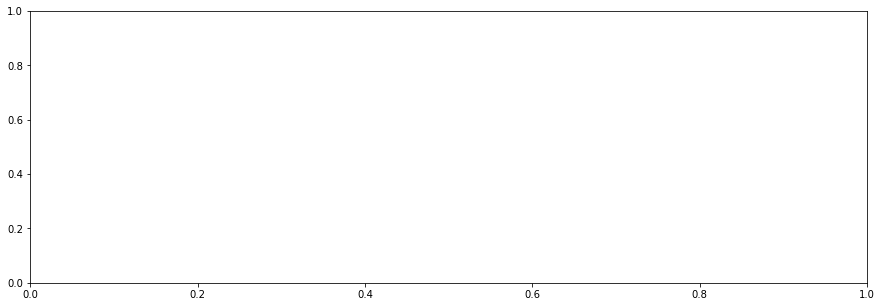

In [18]:
from sklearn.cluster import KMeans

X = masked_flat_xds[:,20:]
distorsions = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [72]:
from sklearn.cluster import KMeans

# X = masked_flat_xds[:,20:]
X = (masked_flat_xds[:,20:].T/masked_flat_xds[:,45]).T

kmeans = KMeans(n_clusters=5, random_state=42,).fit(X)

In [73]:
all_clusters = np.zeros(flat_xds.shape[0])-1
all_clusters[mask] = kmeans.labels_

In [74]:
np.unique(all_clusters, return_counts=True)

(array([-1.,  0.,  1.,  2.,  3.,  4.]),
 array([2044254,   32157,   38549,   42181,    7969,   10010]))

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(X)

In [76]:
all_pca = np.zeros((flat_xds.shape[0],2))
all_pca[:] = np.nan
all_pca[mask] = pca

In [77]:
colors = ["blue","orange", 'grey', 'red', 'darkgreen']

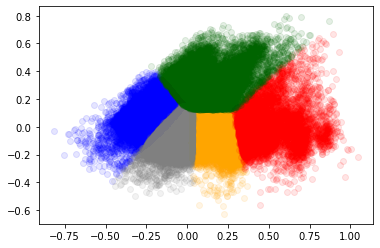

In [78]:
fig, ax = plt.subplots()

for cluster_n in range(5):
    ax.scatter(pca[:,0][kmeans.labels_==cluster_n],pca[:,1][kmeans.labels_==cluster_n],color=colors[cluster_n],alpha=0.1)

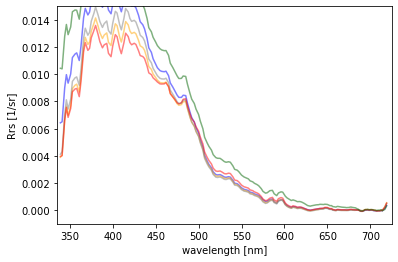

In [79]:
for cluster_n in range(5):
    plt.plot(wls,np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0),color=colors[cluster_n],alpha=0.5)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')
plt.ylim(-0.001,0.015)
plt.xlim(335,725)

fig.tight_layout()

# plt.savefig('figs/spectra_examples_nw_atlantic_oci.png',dpi=300)

plt.show()

In [80]:
xds_subset

<xarray.Dataset>
Dimensions:          (wl: 184, x: 1710, y: 1272)
Coordinates:
    latitude         (x, y) float32 15.22 15.23 15.24 ... 38.21 38.22 38.23
    longitude        (x, y) float32 -75.64 -75.58 -75.51 ... -53.05 -52.97
    wavelength       (wl) int32 339 341 344 346 348 351 ... 712 713 714 717 719
Dimensions without coordinates: wl, x, y
Data variables:
    Rrs              (x, y, wl) float32 nan nan nan nan nan ... nan nan nan nan
    kmeans_clusters  (x, y) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    outlier_score    (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
    outlier_labels   (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/45)
    title:                             OCI Level-2 Data
    product_name:                      PACE_OCI.20240420T170201.L2.OC_AOP.V1_...
    processing_version:                V1.0.0
    history:                           l2gen par=/data1/sdpsoper/vdc/vpu0/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -75.64262
    geospatial_lon_min:                -52.96996
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9903827905654907

In [81]:
# kmeans_grid = all_clusters.reshape(1709,1272)
kmeans_grid = all_clusters.reshape(1710,1272)

In [82]:
xds_subset['kmeans_clusters'] = xr.DataArray(kmeans_grid, dims=['x', 'y'])

In [83]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','white','white',"white","blue","orange", 'grey', 'red', 'darkgreen'])

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


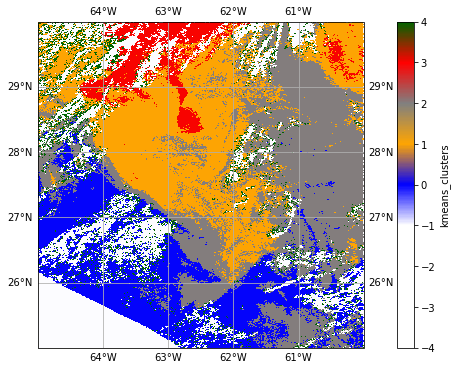

In [84]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

ax.set_xlim(-65,-60)
ax.set_ylim(25,30)

xds_subset.kmeans_clusters.plot(ax=ax, x='longitude', y='latitude', cmap=cmap)

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

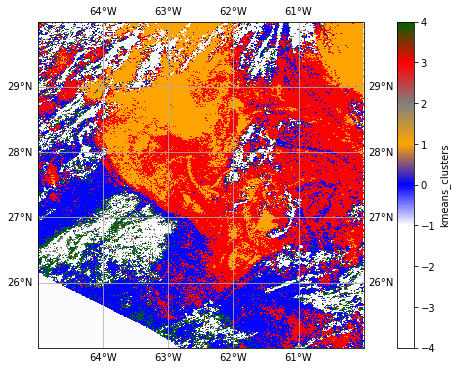

In [34]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

ax.set_xlim(-65,-60)
ax.set_ylim(25,30)

xds_subset.kmeans_clusters.plot(ax=ax, x='longitude', y='latitude', cmap=cmap)

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

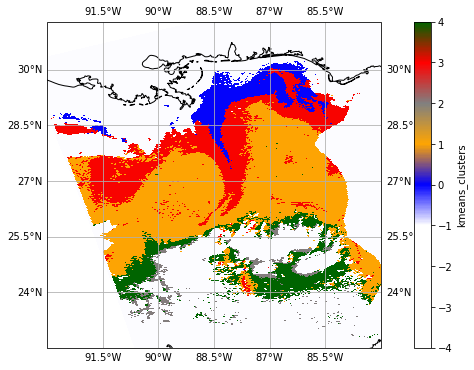

In [33]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

ax.set_ylim(22.5,31.3)
ax.set_xlim(-93,-84)

xds_subset.kmeans_clusters.plot(ax=ax, x='longitude', y='latitude', cmap=cmap)

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

In [85]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0)
outlier_labels = clf.fit_predict(X)

In [ ]:
outlier_score = clf.decision_function(X)

In [ ]:
plt.hist(outlier_score)

In [ ]:
fig, ax = plt.subplots()

im = ax.scatter(pca[:,0],pca[:,1],c=outlier_score,alpha=0.1)
fig.colorbar(im)

plt.show()

In [ ]:
fig, ax = plt.subplots()

im = ax.scatter(pca[:,0],pca[:,1],c=outlier_labels,alpha=0.1)
fig.colorbar(im)

plt.show()

In [ ]:
all_outliers = np.zeros(flat_xds.shape[0])
all_outliers[:] = np.nan
all_outliers[mask] = outlier_score

outlier_grid = all_outliers.reshape(1710,1272)

xds_subset['outlier_score'] = xr.DataArray(outlier_grid, dims=['x', 'y'])

In [ ]:
all_outlier_labs = np.zeros(flat_xds.shape[0])
all_outlier_labs[:] = np.nan
all_outlier_labs[mask] = outlier_labels

outlier_lab_grid = all_outlier_labs.reshape(1710,1272)

xds_subset['outlier_labels'] = xr.DataArray(outlier_lab_grid, dims=['x', 'y'])

In [ ]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

ax.set_xlim(-65,-60)
ax.set_ylim(25,30)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

xds_subset.outlier_labels.plot(ax=ax, x='longitude', y='latitude', cmap='cividis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


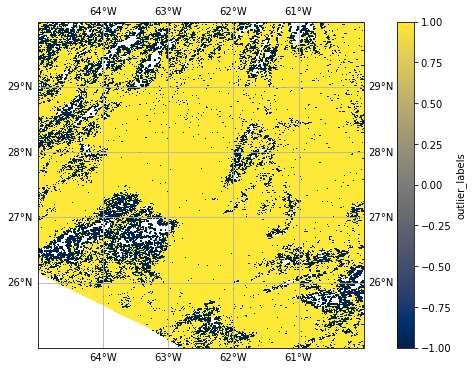

In [42]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

ax.set_xlim(-65,-60)
ax.set_ylim(25,30)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

xds_subset.outlier_labels.plot(ax=ax, x='longitude', y='latitude', cmap='cividis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

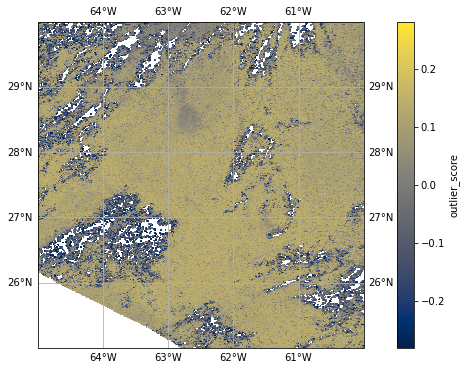

In [43]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

ax.set_xlim(-65,-60)
ax.set_ylim(25,30)

xds_subset.outlier_score.plot(ax=ax, x='longitude', y='latitude', cmap='cividis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

In [ ]:
ind = np.argpartition(outlier_score, 500)[:500]

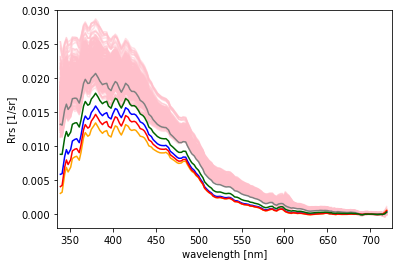

In [46]:
plt.plot(wls,masked_flat_xds[ind].T,c='pink', alpha=0.5)

for cluster_n in range(5):
    plt.plot(wls,np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0),color=colors[cluster_n],alpha=1)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')
plt.ylim(-0.002,0.03)
plt.xlim(335,725)

fig.tight_layout()

# plt.savefig('figs/spectra_examples_nw_atlantic_oci.png',dpi=300)

plt.show()

In [48]:
np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)[45]

0.011704801

In [62]:
np.mean(masked_flat_xds[ind].T,axis=1).shape

(184,)

(184, 500)

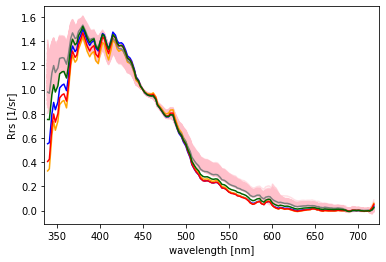

In [65]:
plt.plot(wls,masked_flat_xds[ind].T/masked_flat_xds[ind].T[45],c='pink', alpha=0.5)

for cluster_n in range(5):
    plt.plot(wls,np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)/np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)[45],color=colors[cluster_n],alpha=1)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')
# plt.ylim(-0.002,0.03)
plt.xlim(335,725)

fig.tight_layout()

# plt.savefig('figs/spectra_examples_nw_atlantic_oci.png',dpi=300)

plt.show()

In [ ]:
plt.plot(wls,masked_flat_xds[ind].T/masked_flat_xds[ind].T[45],c='pink', alpha=0.5)

for cluster_n in range(5):
    plt.plot(wls,np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)/np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)[45],color=colors[cluster_n],alpha=1)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')
# plt.ylim(-0.002,0.03)
plt.xlim(335,725)

fig.tight_layout()

# plt.savefig('figs/spectra_examples_nw_atlantic_oci.png',dpi=300)

plt.show()